In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
import os
from tqdm import tqdm_notebook
from skimage.transform import resize
from keras.preprocessing.image import load_img

Using TensorFlow backend.


In [2]:
path = '/media/danil/Data/Datasets/CelebA/Img'
path_to_img = '/media/danil/Data/Datasets/CelebA/Img/img_align_celeba'
BATCH_SIZE = 32

In [3]:
training = pd.read_csv(os.path.join(path,'list_attr_celeba.txt'), delimiter=" ")
training.Smiling = training.Smiling.map({1:1, -1:0})
training.head()

,ImageName,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,0,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,0,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,0,-1,-1,-1,-1,1,-1,-1,1


In [4]:
open_mouth_df = pd.read_csv(os.path.join(path,'CelebA.csv'))
open_mouth_df.columns = ['ImageName', 'open_mouth']
open_mouth_df.head()

,ImageName,open_mouth
0,055997.jpg,1
1,131827.jpg,1
2,052069.jpg,1
3,110305.jpg,1
4,098890.jpg,1


In [5]:
training = pd.merge(training, open_mouth_df, how='right', on='ImageName')
training.head()

,ImageName,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,open_mouth
0,000077.jpg,-1,-1,1,-1,-1,1,-1,-1,-1,...,1,-1,1,-1,-1,1,-1,-1,1,0
1,000090.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,0,1,-1,-1,-1,-1,-1,-1,1,0
2,000102.jpg,-1,-1,-1,-1,-1,-1,-1,-1,1,...,0,-1,-1,-1,-1,-1,-1,-1,1,0
3,000115.jpg,-1,-1,-1,-1,1,-1,-1,-1,-1,...,0,-1,-1,-1,-1,-1,-1,-1,-1,0
4,000149.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,-1,-1,-1,1,-1,-1,-1,1,1


In [6]:
training.shape

(3724, 42)

In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
X_train_cv = skf.split(training.values, training['Smiling'].values)

index_train_dict = {}
index_test_dict = {}
for i in range(5):
    ind = next(X_train_cv)
    index_train_dict['split_{}'.format(i)] = ind[0]
    index_test_dict['split_{}'.format(i)] = ind[1]

In [8]:
from sklearn.utils import shuffle
import cv2 as cv

In [9]:
face_cascade = cv.CascadeClassifier('/media/danil/Data/Kaggle/airbus-ship-detection/venv/lib/python3.5/site-packages/cv2/data/haarcascade_frontalface_default.xml')
def cascadeHaar(img):
    img = np.array(img, dtype=np.uint8)
    faces = face_cascade.detectMultiScale(img, 1.3, 5)
    for face in faces:
        img = img[max(0,face[1]):max(0,face[1])+max(0,face[3]), max(0,face[0]):max(0,face[0])+max(0,face[2])]
        return img, 1
    return img, 0

In [10]:
import dlib
hog_face_detector = dlib.get_frontal_face_detector()
def hog_face_detection(img):
    faces_hog = hog_face_detector(img, 1)
    for face in faces_hog:
        img = img[max(0,face.top()):max(0,face.bottom()), max(0,face.left()):max(0,face.right())]
        return img, 1
    return img, 0

cnn_face_detector = dlib.cnn_face_detection_model_v1('mmod_human_face_detector.dat')
def cnn_face_detection(img):
    faces_cnn = cnn_face_detector(img, 1)
    for face in faces_cnn:
        img = img[max(0,face.rect.top()):max(0,face.rect.bottom()), max(0,face.rect.left()):max(0,face.rect.right())]
        return img, 1
    return img, 0

from mtcnn.mtcnn import MTCNN
detector = MTCNN()
def mtcnn_detect(img):
    faces = detector.detect_faces(img)
    for face in faces:
        img = img[max(0,face['box'][1]):max(0,face['box'][1]) + max(0,face['box'][3]), 
                  max(0,face['box'][0]): max(0,face['box'][0]) + max(0,face['box'][2])]
        return img, 1
    return img, 0

def get_face(img):
    img, label = mtcnn_detect(img)
    if label==0:
        img, label = hog_face_detection(img)
        if label==0:
            img, label = cnn_face_detection(img)
            if label==0:
                img, label = cascadeHaar(img)
    return img, label

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [11]:
training = shuffle(training)
out_rgb = []
out_smiles = []
out_mouths = []
for path_img, smile, open_mouth in tqdm_notebook(training[['ImageName', 'Smiling', 'open_mouth']].values[:10]):
    img = cv.imread(os.path.join(path_to_img, path_img))
    img, label = get_face(img)
    img = resize(img, (224,224,3))
    out_rgb += [img]
    out_smiles += [smile]
    out_mouths += [open_mouth]
    if label == 0:
        out_rgb.pop()
        out_smiles.pop()
        out_mouths.pop()

/media/danil/Data/Kaggle/airbus-ship-detection/venv/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/media/danil/Data/Kaggle/airbus-ship-detection/venv/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [12]:
out_smiles += out_smiles
out_mouths += out_mouths
x_train = np.append(out_rgb, [np.fliplr(x) for x in out_rgb], axis=0)

# Build Model

In [13]:
from keras import backend as K
K.clear_session()

In [14]:
from keras.applications import NASNetMobile
model = NASNetMobile(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))

from keras.layers import Flatten, Dense, Dropout, BatchNormalization, GlobalMaxPooling2D
from keras.regularizers import l2
#Adding custom Layers 
x = model.output
x = BatchNormalization()(x)
x = GlobalMaxPooling2D()(x)

x1 = Dense(1024, activation="elu", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.5)(x1)
x1 = Dense(256, activation="elu", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x1)
x1 = BatchNormalization()(x1)
#x1 = Dropout(0.5)(x1)

x2 = Dense(1024, activation="elu", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.5)(x2)
x2 = Dense(256, activation="elu", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x2)
x2 = BatchNormalization()(x2)
#x2 = Dropout(0.5)(x2)

out_smile = Dense(1, activation="sigmoid", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001), name='out_smile')(x1)
out_mouth = Dense(1, activation="sigmoid", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001), name='out_mouth')(x2)

from keras.models import Model
# creating the final model 
model_final = Model(input = model.input, output = [out_smile, out_mouth])

/media/danil/Data/Kaggle/airbus-ship-detection/venv/lib/python3.5/site-packages/ipykernel_launcher.py:30: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


In [15]:
from keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc, roc_auc_score
from keras.models import Model

from keras import backend as K
import tensorflow as tf
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc
  
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model 
model_final.compile(loss = {'out_smile':"binary_crossentropy", 'out_mouth':"binary_crossentropy"}, optimizer = Adam(lr=0.001, decay=0.0001), metrics=[f1], loss_weights=[0.5, 0.5])

In [16]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

weight_path='solution1.h5'

checkpoint = ModelCheckpoint(weight_path, monitor='val_out_smile_f1', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only=True)


def exp_decay(epoch):
    initial_lrate = 0.001
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate
lrate = LearningRateScheduler(exp_decay)

callbacks_list = [lrate, checkpoint]

In [17]:
model_final.fit(x_train, 
                [out_smiles, out_mouths],
                epochs = 30,
                batch_size = 64, 
                validation_split=0.15,
                callbacks = callbacks_list,
                initial_epoch = 0)

Train on 6300 samples, validate on 1112 samples
Epoch 1/30
6300/6300 [==============================] - 119s 19ms/step - loss: 0.7057 - out_smile_loss: 0.3914 - out_mouth_loss: 0.4297 - out_smile_f1: 0.8343 - out_mouth_f1: 0.8192 - val_loss: 0.6402 - val_out_smile_loss: 0.4515 - val_out_mouth_loss: 0.2423 - val_out_smile_f1: 0.8211 - val_out_mouth_f1: 0.8711

Epoch 00001: val_out_smile_f1 improved from -inf to 0.82114, saving model to solution1.h5
Epoch 2/30
6300/6300 [==============================] - 78s 12ms/step - loss: 0.3933 - out_smile_loss: 0.1987 - out_mouth_loss: 0.0138 - out_smile_f1: 0.9154 - out_mouth_f1: 0.9259 - val_loss: 0.6298 - val_out_smile_loss: 0.2072 - val_out_mouth_loss: 0.4924 - val_out_smile_f1: 0.9089 - val_out_mouth_f1: 0.7726

Epoch 00002: val_out_smile_f1 improved from 0.82114 to 0.90890, saving model to solution1.h5
Epoch 3/30
6300/6300 [==============================] - 77s 12ms/step - loss: 0.2886 - out_smile_loss: 0.1388 - out_mouth_loss: -0.1082 - out_

# TEST

In [30]:
model_final.load_weights(weight_path)

In [19]:
path_test = '/media/danil/Data/Datasets/example_data'
test_images = os.listdir(os.path.join(path_test,'images'))
test_images = [i for i in test_images if 'jpg' in i]

test_smile = os.listdir(os.path.join(path_test,'smile'))
test_smile = [i for i in test_smile if 'jpg' in i]

test_open_mouth = os.listdir(os.path.join(path_test,'open_mouth'))
test_open_mouth = [i for i in test_open_mouth if 'jpg' in i]

In [20]:
test_mouth = []
for i in test_images:
    if i in test_open_mouth:
        test_mouth += [1]
    else:
        test_mouth += [0]
sum(test_mouth)

38

In [21]:
test_smiles = []
for i in test_images:
    if i in test_smile:
        test_smiles += [1]
    else:
        test_smiles += [0]
sum(test_smiles)

23

In [22]:
test_df = pd.DataFrame()
test_df['image'] = test_images
test_df['smile'] = test_smiles
test_df['mouth'] = test_smiles

In [23]:
import gc
del out_rgb, x_train
gc.collect()

510809

In [24]:
test_imgs = [cv.imread(os.path.join(path_test, 'images', i)) for i in test_images]
test_imgs = [resize(get_face(i)[0], (224,224,3)) for i in tqdm_notebook(test_imgs)]

/media/danil/Data/Kaggle/airbus-ship-detection/venv/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/media/danil/Data/Kaggle/airbus-ship-detection/venv/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [25]:
from sklearn.metrics import roc_auc_score, f1_score

In [31]:
predict = model_final.predict(np.stack(test_imgs, 0))

In [32]:
score_smile = roc_auc_score(test_df.smile.values, predict[0])
score_mouth = roc_auc_score(test_df.mouth.values, predict[1])

f1_score_smile = f1_score(test_df.smile.values, np.round(predict[0]))
f1_score_mouth = f1_score(test_df.mouth.values, np.round(predict[1]))

In [33]:
print(f1_score_smile)
print(f1_score_mouth)

0.547945205479452
0.3692307692307692


In [34]:
print(score_smile)
print(score_mouth)

0.9386281588447654
0.8177680113012087


In [35]:
tresh = np.arange(0.1, 0.9, 0.05)
scores_smile = []
scores_mouth = []
for i in tresh:
    scores_smile += [f1_score(test_df.smile.values, np.array(predict[0]>i, dtype=int))]
    scores_mouth += [f1_score(test_df.mouth.values, np.array(predict[1]>i, dtype=int))]

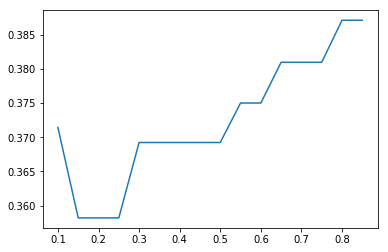

In [37]:
plt.plot(tresh, scores_mouth)